In [93]:
from math import floor 

def discretize(waiting_times):
    
    return int(100000*abs(round(waiting_times[0], 1)) + 1000*abs(round(waiting_times[1], 1)) + 10*abs(round(waiting_times[2], 1)))

In [94]:
def append_packets(packet_info, queues, time):
    for i in range(len(packet_info)):
            for sublist in packet_info:
                if sublist[0] == i:
                    whole_packets = floor((time*sublist[1] - sublist[3]))
                    if whole_packets > 0:
                        queues[i].append(1)
                        print("Appending to queue", i)
                        sublist[3] += 1
                        
def calc_reward(curr_mean_delay_best_effort, current_waiting_time, queues, action):
#   heavily penalize for choosing empty queue
    if (len(queues[action]) == 0):
        return -25
#   reward for clearing list
    elif not any(queues):
        return 25
#   penalize for not popping queue 1 when it has a mean delay over 4
    elif current_waiting_time[0] < -4 and action != 0:
        return -10
#   penalize for not popping queue 2 when it has a mean delay over 6
    elif current_waiting_time[1] < -6 and action != 1:
        return -10
    else:
        if curr_mean_delay_best_effort == 0:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       reward if model improves mean_delay in best effort
        elif curr_mean_delay_best_effort < current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       penalize slightly if model mean_delay in best effort queue increases
        elif curr_mean_delay_best_effort > current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            reward = -1
        else:
            reward = 1

def add_time(queue):
    for i in range(len(queue)):
        queue[i] -= 1

def calc_mean_delay(queue):
    # Calculate the length and average waiting time of the current queue
    current_length = len(queue)
    current_waiting_time = np.average(queue) if current_length > 0 else 0.0
    #print(np.average(current_queue), current_length, current_waiting_time )
    current_waiting_time = np.round(current_waiting_time, 1)
    return current_waiting_time

def catch_over_ten_second_mean_delay(waiting_time):
    if waiting_time > 9.9:
        waiting_time = 9.9

In [98]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    def __init__(self):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(1000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        self.dataType = [0, 1, 2]
        self.arrival_rate = [0.3, 0.25, 0.4]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)

        
        #OBSERVING ENVRONEMNT
        observation = []
        
        append_packets(self.packetInfo, self.queues, self.totaltime)
        
        for i in range(len(self.mean_delay_req)):
            add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue
            current_waiting_time = calc_mean_delay(current_queue)
            observation.append(current_waiting_time)
            
        reward = calc_reward(self.curr_mean_delay_best_effort, observation, self.queues, action)
        
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        #done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 100)
        print(observation)
        for i in range(3):
            catch_over_ten_second_mean_delay(observation[i])
        #print(f"WAITING TIMES {np.array(waiting_times)}")
        waiting_times = discretize(observation)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.totaltime = 1
        return [0,0,0]
        
    def render(self):
        pass

In [99]:
env = TrafficGenerator()
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(1000000)
Action space:  Discrete(3)


env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs, reward, done, info = env.step(action)
    print(info)
    print(obs)
    print("reward", reward)
    
    x = x + 1

In [108]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []
# Hyperparameters

total_episodes = 400
total_test_episodes = 50
max_steps = 999
learning_rate = 0.1
gamma = 0.618
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Train
for episode in range(total_episodes):
    state = env.reset()
    total_rewards = 0
    print("Episode ", episode,"/", total_episodes )
    for step in range(max_steps):
        exp_exp_tradeoff = random.uniform(0, 1)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state, :])
        else:
            action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        total_rewards += reward
        print(new_state)
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
        state = new_state
        print(total_rewards)
        if done: 
            rewardstest.append(total_rewards)
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))




Episode  0 / 400
[0.0, 0.0, 0.0]
0
-25
Appending to queue 2
[0.0, 0.0, 0.0]
0
-50
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
0
-75
Appending to queue 2
[-1.0, -1.0, 0.0]
101000
-74
[0.0, -2.0, -1.0]
2010
-99
Appending to queue 0
[0.0, 0.0, -2.0]
20
-124
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -1.5]
100015
-123
[0.0, -1.0, -2.5]
1025
-148
Appending to queue 0
Appending to queue 2
[0.0, -2.0, -2.3]
2023
-147
[-1.0, -3.0, -2.0]
103020
-146
Appending to queue 1
[-2.0, -2.0, -2.0]
202020
-145
Appending to queue 2
[-3.0, -3.0, 0.0]
303000
-144
Appending to queue 0
[-2.0, -4.0, 0.0]
204000
-169
Appending to queue 2
[-3.0, -5.0, 0.0]
305000
-168
Appending to queue 1
[-4.0, -4.0, 0.0]
404000
-193
Appending to queue 0
[-3.3, -5.0, 0.0]
335000
-218
Appending to queue 2
[-4.3, -6.0, 0.0]
436000
-228
[-3.5, -7.0, -1.0]
357010
-238
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -6.0, -1.0]
156010
-237
[-2.5, -5.0, -2.0]
255020
-236
[-3.5, -6.0, -2.

[-2.0, -3.0, -1.0]
203010
-391
Appending to queue 0
Appending to queue 2
[0.0, -4.0, -1.0]
4010
-390
[-1.0, -3.0, -2.0]
103020
-389
Appending to queue 1
[-2.0, -2.0, -2.0]
202020
-388
Appending to queue 2
[-3.0, -1.0, -1.5]
301015
-387
Appending to queue 0
[-2.0, -2.0, -1.0]
202010
-386
Appending to queue 2
[-1.0, -3.0, -1.0]
103010
-385
Appending to queue 1
[-2.0, -2.0, -1.0]
202010
-384
Appending to queue 0
[-1.5, -1.0, -2.0]
151020
-383
Appending to queue 2
[-2.5, 0.0, -1.5]
250015
-408
[-3.5, 0.0, -2.5]
350025
-433
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-3.0, 0.0, -1.0]
300010
-432
Episode  90 / 400
[0.0, 0.0, 0.0]
0
-25
Appending to queue 2
[0.0, 0.0, 0.0]
0
-50
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
0
-75
Appending to queue 2
[0.0, -1.0, 0.0]
1000
-100
[0.0, -2.0, -1.0]
2010
-125
Appending to queue 0
[0.0, 0.0, -2.0]
20
-150
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -1.5]
100015
-149
[-2.0, -1.0, -1.0]
201010
-148
Appending 

-25
Appending to queue 2
[0.0, 0.0, 0.0]
0
-24
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
0
-49
Appending to queue 2
[-1.0, -1.0, 0.0]
101000
-48
[-2.0, 0.0, -1.0]
200010
-73
Appending to queue 0
[-1.5, 0.0, 0.0]
150000
-98
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
100000
-97
[0.0, -1.0, -1.0]
1010
-122
Appending to queue 0
Appending to queue 2
[0.0, -2.0, -1.0]
2010
-121
[-1.0, -3.0, -1.0]
103010
-120
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-119
Appending to queue 2
[-3.0, -1.0, 0.0]
301000
-118
Appending to queue 0
[0.0, -2.0, -1.0]
2010
-117
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-116
Appending to queue 1
[0.0, -2.0, -1.0]
2010
-141
Appending to queue 0
[0.0, -3.0, 0.0]
3000
-166
Appending to queue 2
[-1.0, -2.0, 0.0]
102000
-165
[-2.0, 0.0, -1.0]
200010
-190
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -1.0]
10
-189
[-1.0, 0.0, -2.0]
100020
-214
[-2.0, 0.0, -3.0]
200030
-239
Appending to queue 2
[-3.0, 0.0, -

Appending to queue 0
[0.0, -3.0, -2.0]
3020
-156
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -1.5]
100015
-155
[-2.0, -1.0, -1.0]
201010
-154
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-153
[-1.0, -3.0, -1.0]
103010
-152
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-151
Appending to queue 2
[-3.0, -1.0, 0.0]
301000
-150
Appending to queue 0
[0.0, -2.0, -1.0]
2010
-149
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-148
Appending to queue 1
[-2.0, 0.0, -1.0]
200010
-147
Appending to queue 0
[0.0, -1.0, -2.0]
1020
-146
Appending to queue 2
[-1.0, 0.0, -1.5]
100015
-171
[0.0, 0.0, -2.5]
25
-196
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -2.3]
23
-195
[-1.0, -1.0, -2.0]
101020
-194
[-2.0, -2.0, -2.0]
202020
-193
Appending to queue 2
[0.0, -3.0, -1.5]
3015
-218
Appending to queue 0
Appending to queue 1
[0.0, -2.0, -2.5]
2025
-217
Appending to queue 2
[-1.0, -3.0, -1.0]
103010
-216
[-2.0, -2.0, -2.0]
202020
-215
Appending to qu

Appending to queue 0
Appending to queue 1
[0.0, -4.0, -1.0]
4010
-113
Appending to queue 2
[-1.0, -3.0, -1.0]
103010
-112
[-2.0, -2.0, -2.0]
202020
-111
Appending to queue 0
[-1.5, -3.0, -2.0]
153020
-110
Appending to queue 1
Appending to queue 2
[-1.0, -2.0, -1.5]
102015
-109
[-2.0, -3.0, -1.0]
203010
-108
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, -1.0]
152010
-107
[-2.5, -3.0, -1.0]
253010
-106
Appending to queue 1
[-2.0, -2.0, -2.0]
202020
-105
Appending to queue 2
[-3.0, -3.0, 0.0]
303000
-104
Appending to queue 0
[-2.0, -4.0, 0.0]
204000
-129
Appending to queue 2
[-3.0, -5.0, 0.0]
305000
-128
Appending to queue 1
[-2.0, -4.0, -1.0]
204010
-127
Appending to queue 0
[0.0, -5.0, -2.0]
5020
-126
Appending to queue 2
[-1.0, -4.0, -1.5]
104015
-125
[-2.0, -3.0, -2.5]
203025
-124
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, 0.0, -2.3]
150023
-123
[-2.5, -1.0, -2.0]
251020
-122
[-2.0, -2.0, -3.0]
202030
-121
Appending to queue 2
[0.0, -3.0, -2.7]
3027

[-1.0, -1.0, -2.0]
101020
-206
[-2.0, -2.0, -2.0]
202020
-205
Appending to queue 2
[-3.0, -3.0, 0.0]
303000
-204
Appending to queue 0
Appending to queue 1
[0.0, -2.0, -1.0]
2010
-203
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-202
[-2.0, -2.0, -1.0]
202010
-201
Appending to queue 0
[0.0, -3.0, -2.0]
3020
-200
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -1.5]
100015
-199
[-2.0, -1.0, -1.0]
201010
-198
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-197
[-1.0, -3.0, -1.0]
103010
-196
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-195
Appending to queue 2
[-3.0, -1.0, 0.0]
301000
-194
Appending to queue 0
[0.0, -2.0, -1.0]
2010
-193
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-192
Appending to queue 1
[-2.0, 0.0, -1.0]
200010
-191
Appending to queue 0
[0.0, -1.0, -2.0]
1020
-190
Appending to queue 2
[-1.0, -2.0, 0.0]
102000
-189
[-2.0, -3.0, 0.0]
203000
-214
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-213
Epis

Appending to queue 0
Appending to queue 1
[0.0, -2.0, -2.5]
2025
-217
Appending to queue 2
[-1.0, -3.0, -1.0]
103010
-216
[-2.0, -2.0, -2.0]
202020
-215
Appending to queue 0
[-1.5, -3.0, -2.0]
153020
-214
Appending to queue 1
Appending to queue 2
[-1.0, -2.0, -1.5]
102015
-213
[-2.0, -3.0, -1.0]
203010
-212
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, -1.0]
152010
-211
[-2.5, -3.0, -1.0]
253010
-210
Appending to queue 1
[-2.0, -2.0, -2.0]
202020
-209
Appending to queue 2
[-3.0, -3.0, 0.0]
303000
-208
Appending to queue 0
[0.0, -4.0, -1.0]
4010
-207
Appending to queue 2
[-1.0, -3.0, -1.0]
103010
-206
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-205
Appending to queue 0
[-1.5, -1.0, -2.0]
151020
-204
Appending to queue 2
[-1.0, -2.0, -1.5]
102015
-203
[-2.0, -3.0, -1.0]
203010
-202
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, 0.0, -1.0]
150010
-201
[-1.0, -1.0, -2.0]
101020
-200
[-2.0, -2.0, -2.0]
202020
-199
Appending to queue 2
[-3.0, -3.0, 0.0]
303

[0.0, 0.0, 0.0]
0
-25
Appending to queue 2
[0.0, 0.0, 0.0]
0
-24
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
0
-49
Appending to queue 2
[-1.0, -1.0, 0.0]
101000
-48
[0.0, -2.0, -1.0]
2010
-73
Appending to queue 0
[0.0, -3.0, 0.0]
3000
-98
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
100000
-97
[-2.0, -1.0, 0.0]
201000
-122
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-121
[-1.0, -3.0, -1.0]
103010
-120
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-119
Appending to queue 2
[-3.0, -1.0, 0.0]
301000
-118
Appending to queue 0
[0.0, -2.0, -1.0]
2010
-117
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-116
Appending to queue 1
[-2.0, 0.0, -1.0]
200010
-115
Appending to queue 0
[0.0, -1.0, -2.0]
1020
-114
Appending to queue 2
[-1.0, -2.0, 0.0]
102000
-113
[-2.0, -3.0, 0.0]
203000
-138
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-137
[-1.0, -3.0, -1.0]
103010
-136
[-2.0, -2.0, -2.0]
202020
-135
Append

-25
Appending to queue 2
[0.0, 0.0, 0.0]
0
-24
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
0
-49
Appending to queue 2
[-1.0, -1.0, 0.0]
101000
-48
[0.0, -2.0, -1.0]
2010
-73
Appending to queue 0
[0.0, -3.0, 0.0]
3000
-98
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
100000
-97
[-2.0, -1.0, 0.0]
201000
-122
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-121
[-1.0, -3.0, -1.0]
103010
-120
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-119
Appending to queue 2
[-3.0, -1.0, 0.0]
301000
-118
Appending to queue 0
[0.0, -2.0, -1.0]
2010
-117
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-116
Appending to queue 1
[-2.0, 0.0, -1.0]
200010
-115
Appending to queue 0
[0.0, -1.0, -2.0]
1020
-114
Appending to queue 2
[-1.0, -2.0, 0.0]
102000
-113
[-2.0, -3.0, 0.0]
203000
-138
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-137
[-1.0, -3.0, -1.0]
103010
-136
[0.0, -4.0, -2.0]
4020
-161
Appending to queue 2
[0.0, 

[-2.0, -2.0, -1.0]
202010
-189
Appending to queue 0
[0.0, -3.0, -2.0]
3020
-188
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -1.5]
100015
-187
[-2.0, 0.0, -2.5]
200025
-212
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -2.3]
23
-211
[-1.0, 0.0, -2.0]
100020
-210
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-209
Appending to queue 2
[-3.0, -1.0, 0.0]
301000
-208
Appending to queue 0
[0.0, -2.0, -1.0]
2010
-207
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-206
Appending to queue 1
[-2.0, 0.0, -1.0]
200010
-205
Appending to queue 0
[0.0, -1.0, -2.0]
1020
-204
Appending to queue 2
[-1.0, -2.0, 0.0]
102000
-203
[-2.0, -3.0, 0.0]
203000
-228
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-227
[-1.0, -3.0, -1.0]
103010
-226
[-2.0, -2.0, -2.0]
202020
-225
Appending to queue 2
[-3.0, -3.0, 0.0]
303000
-224
Appending to queue 0
Appending to queue 1
[0.0, -2.0, -1.0]
2010
-223
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-222
[-2.0, -2.0

-25
Appending to queue 2
[0.0, 0.0, 0.0]
0
-50
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
0
-75
Appending to queue 2
[-1.0, -1.0, 0.0]
101000
-74
[0.0, -2.0, -1.0]
2010
-99
Appending to queue 0
[0.0, -3.0, 0.0]
3000
-124
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
100000
-123
[0.0, -1.0, -1.0]
1010
-148
Appending to queue 0
Appending to queue 2
[0.0, -2.0, 0.0]
2000
-147
[-1.0, 0.0, -1.0]
100010
-172
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-171
Appending to queue 2
[-3.0, -1.0, 0.0]
301000
-170
Appending to queue 0
[0.0, -2.0, -1.0]
2010
-169
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-168
Appending to queue 1
[-2.0, 0.0, -1.0]
200010
-167
Appending to queue 0
[0.0, -1.0, -2.0]
1020
-166
Appending to queue 2
[-1.0, -2.0, 0.0]
102000
-165
[-2.0, -3.0, 0.0]
203000
-190
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-189
[-1.0, -3.0, -1.0]
103010
-188
[-2.0, -2.0, -2.0]
202020
-187
Appending to queue 2
[-3.0, 

-25
Appending to queue 2
[0.0, 0.0, 0.0]
0
-24
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
0
-49
Appending to queue 2
[-1.0, -1.0, 0.0]
101000
-48
[0.0, -2.0, -1.0]
2010
-73
Appending to queue 0
[0.0, -3.0, 0.0]
3000
-98
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
100000
-97
[-2.0, -1.0, 0.0]
201000
-122
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-121
[-1.0, -3.0, -1.0]
103010
-120
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-119
Appending to queue 2
[-3.0, -1.0, 0.0]
301000
-118
Appending to queue 0
[0.0, -2.0, -1.0]
2010
-117
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-116
Appending to queue 1
[-2.0, 0.0, -1.0]
200010
-115
Appending to queue 0
[0.0, -1.0, -2.0]
1020
-114
Appending to queue 2
[-1.0, -2.0, 0.0]
102000
-113
[-2.0, -3.0, 0.0]
203000
-138
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-137
[-1.0, -3.0, -1.0]
103010
-136
[-2.0, -2.0, -2.0]
202020
-135
Appending to queue 2
[-3

Appending to queue 2
[-3.0, -1.0, 0.0]
301000
-118
Appending to queue 0
[0.0, -2.0, -1.0]
2010
-117
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-116
Appending to queue 1
[-2.0, 0.0, -1.0]
200010
-115
Appending to queue 0
[0.0, -1.0, -2.0]
1020
-114
Appending to queue 2
[-1.0, -2.0, 0.0]
102000
-113
[-2.0, -3.0, 0.0]
203000
-138
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-137
[-1.0, -3.0, -1.0]
103010
-136
[-2.0, -2.0, -2.0]
202020
-135
Appending to queue 2
[-3.0, -3.0, 0.0]
303000
-134
Appending to queue 0
Appending to queue 1
[0.0, -2.0, -1.0]
2010
-133
Appending to queue 2
[-1.0, -3.0, 0.0]
103000
-132
[-2.0, -2.0, -1.0]
202010
-131
Appending to queue 0
[0.0, -3.0, -2.0]
3020
-130
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -1.5]
100015
-129
[-2.0, -1.0, -1.0]
201010
-128
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, 0.0]
152000
-127
[-1.0, -3.0, -1.0]
103010
-126
Appending to queue 1
[-2.0, 0.0, -2.0]
200020
-125
Appe

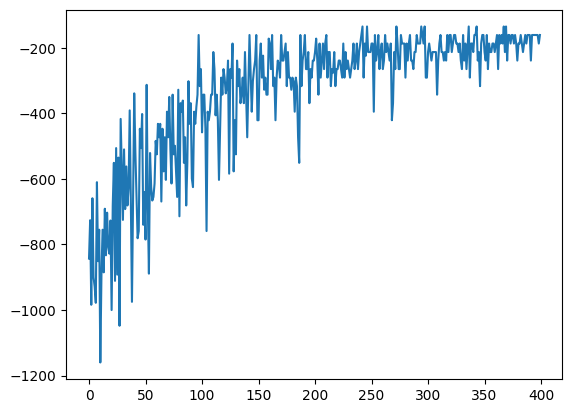

In [109]:
import matplotlib.pyplot as plt
import numpy as np
 #Plot the data\n
plt.plot(rewardstest)
# Show the plot\n",
plt.show()

In [110]:
print(rewardstest)

[-843, -726, -984, -659, -900, -929, -978, -610, -851, -755, -1160, -892, -755, -885, -691, -833, -703, -807, -828, -727, -1000, -681, -551, -911, -506, -892, -535, -1048, -417, -577, -725, -510, -692, -562, -681, -629, -391, -666, -975, -662, -339, -517, -655, -781, -759, -447, -506, -402, -740, -640, -785, -313, -680, -889, -521, -625, -666, -655, -614, -484, -525, -432, -473, -432, -669, -447, -577, -473, -603, -395, -473, -350, -510, -614, -343, -525, -499, -577, -655, -328, -714, -369, -395, -361, -551, -473, -681, -551, -302, -432, -369, -599, -625, -395, -432, -380, -343, -161, -317, -265, -458, -343, -343, -447, -759, -395, -421, -395, -343, -343, -213, -265, -406, -343, -421, -603, -447, -291, -343, -265, -291, -339, -317, -239, -584, -265, -291, -187, -577, -421, -525, -239, -317, -265, -369, -343, -291, -369, -213, -343, -473, -317, -161, -276, -395, -302, -265, -239, -161, -421, -421, -239, -187, -291, -224, -328, -291, -343, -343, -172, -187, -265, -161, -317, -291, -421, 

In [111]:
# Play the Game
rewards = []

for episode in range(total_test_episodes):
    total_rewards = 0
    total_penalties = 0
    state = env.reset()
    print('='*40)
    print("[*] Episode", episode)
    print('='*40)

    for step in range(max_steps):
        env.render()
        action = np.argmax(qtable[state, :])
        state, reward, done, info = env.step(action)
        #print(reward)
        """"
        if reward == -10:
            total_penalties += 1
        else:
            total_rewards += reward
        """
        total_rewards += reward
        #print("total time: {}", env.totaltime)
        if done:
            rewards.append(total_rewards)
            print('[*] Score', total_rewards)
            break

env.close()
print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))

[*] Episode 0
[0.0, 0.0, 0.0]
Appending to queue 2
[0.0, 0.0, 0.0]
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
Appending to queue 2
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
Appending to queue 0
[0.0, -3.0, 0.0]
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, 0.0]
[-1.0, -3.0, -1.0]
Appending to queue 1
[-2.0, 0.0, -2.0]
Appending to queue 2
[-3.0, -1.0, 0.0]
Appending to queue 0
[0.0, -2.0, -1.0]
Appending to queue 2
[-1.0, -3.0, 0.0]
Appending to queue 1
[-2.0, 0.0, -1.0]
Appending to queue 0
[0.0, -1.0, -2.0]
Appending to queue 2
[-1.0, -2.0, 0.0]
[-2.0, -3.0, 0.0]
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -2.0, 0.0]
[-1.0, -3.0, -1.0]
[-2.0, -2.0, -2.0]
Appending to queue 2
[-3.0, -3.0, 0.0]
Appending to queue 0
Appending to queue 1
[0.0, -2.0, -1.0]
Appending to queue 2
[-1.0, -3.0, 0.0]
[-2.0, -2.0, -1.0]
Appending to queue 0
[0.0, -3.0, -2.0]
Appending to queue

[0.0, 0.0, 0.0]
Appending to queue 2
[0.0, 0.0, 0.0]
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
Appending to queue 2
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
Appending to queue 0
[0.0, -3.0, 0.0]
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
Appending to queue 0
Appending to queue 2
[-1.5, -2.0, 0.0]
[-1.0, -3.0, -1.0]
Appending to queue 1
[-2.0, 0.0, -2.0]
Appending to queue 2
[-3.0, -1.0, 0.0]
Appending to queue 0
[0.0, -2.0, -1.0]
Appending to queue 2
[-1.0, -3.0, 0.0]
Appending to queue 1
[-2.0, 0.0, -1.0]
Appending to queue 0
[0.0, -1.0, -2.0]
Appending to queue 2
[-1.0, -2.0, 0.0]
[-2.0, -3.0, 0.0]
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.5, -2.0, 0.0]
[-1.0, -3.0, -1.0]
[-2.0, -2.0, -2.0]
Appending to queue 2
[-3.0, -3.0, 0.0]
Appending to queue 0
Appending to queue 1
[0.0, -2.0, -1.0]
Appending to queue 2
[-1.0, -3.0, 0.0]
[-2.0, -2.0, -1.0]
Appending to queue 0
[0.0, -3.0, -2.0]
Appending to queue 1
Appending t